<img style="float: left;padding: 1.3em" src="https://raw.githubusercontent.com/gw-odw/odw-2023/main/Tutorials/logo.png">  

#  Gravitational Wave Open Data Workshop #6


#### Tutorial 1.2: Introduction to GWpy

This tutorial will briefly describe GWpy, a python package for gravitational astrophysics, and walk-through how you can use this to speed up access to, and processing of, GWOSC data.
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2023/blob/main/Tutorials/Day_1/Tuto%201.2%20Open%20Data%20access%20with%20GWpy.ipynb)


<div class="alert alert-info">This notebook was generated using python 3.9, but should work on python 3.6, 3.7 or 3.8.</div>

##  Installation  (execute only if running on a cloud platform, like Google Colab, or if you haven't done the installation already!)

Note: we use [`pip`](https://docs.python.org/3.9/installing/), but **it is recommended** to use [conda](https://computing.docs.ligo.org/conda/) on your own machine, as explained in the [installation instructions](https://github.com/gw-odw/odw-2023/blob/main/setup.md). This usage might look a little different than normal, simply because we want to do this directly from the notebook.

In [2]:
# -- Uncomment following line if running in Google Colab
#! pip install -q 'gwpy==2.1.3'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [3]:
import gwpy
print(gwpy.__version__)

2.1.3


## A note on object-oriented programming

Before we dive too deeply, it's worth a quick aside on object-oriented programming (OOP).
[GWpy](https://gwpy.github.io/docs/stable/index.html) is heavily object-oriented, meaning almost all of the code you run using GWpy is based around an object of some type, e.g. `TimeSeries`.
Most of the methods (functions) we will use are attached to an object, rather than standing alone, meaning you should have a pretty good idea of what sort of data you are dealing with (without having to read the documentation!).

For a quick overview of object-oriented programming in Python, see [this blog post by Jeff Knupp](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/).

## Handling data in the time domain

#### Finding open data

We have seen already that the `gwosc` module can be used to query for what data are available on [GWOSC](https://www.gw-openscience.org/data/).
The next thing to do is to actually read some open data. Let's try to get some for GW190412, the first detection of a gravitational-wave signal from a significantly unequal-mass BBH (binary black hole system).

We can use the [TimeSeries.fetch_open_data](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.fetch_open_data) method to download data directly from https://www.gw-openscience.org, but we need to know the GPS times.
We can query for the GPS time of an event as follows:

In [4]:
from gwosc.datasets import event_gps
gps = event_gps('GW190412')
print(gps)

1239082262.1


Now we can build a `[start, end)` GPS segment to 10 seconds around this time, using integers for convenience:

In [5]:
segment = (int(gps)-5, int(gps)+5)
print(segment)

(1239082257, 1239082267)


and can now query for the full data.
For this example we choose to retrieve data for the LIGO-Livingston interferometer, using the identifier `'L1'`.
We could have chosen any of

- `'G1'` - GEO600
- `'H1'` - LIGO-Hanford
- `'L1'` - LIGO-Livingston
- `'V1'` - (Advanced) Virgo
- `'K1'` - KAGRA


In [6]:
from gwpy.timeseries import TimeSeries
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
print(ldata)

Fetched 1 URLs from www.gw-openscience.org for [1239082257 .. 1239082267))
Reading data... [Done]
TimeSeries([-8.42597565e-19, -8.52437103e-19, -8.60738804e-19,
            ...,  1.38850270e-19,  1.37760541e-19,
             1.38094202e-19]
           unit: dimensionless,
           t0: 1239082257.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


##### The `verbose=True` flag lets us see that GWpy has discovered one file that provides the data for the given interval, downloaded it, and loaded the data.
The files are not stored permanently, so next time you do the same call, it will be downloaded again, however, if you know you might repeat the same call many times, you can use `cache=True` to store the file on your computer.

Notes: 

* To control the dataset from which your data come from you can use the 'dataset' keyword. It is recommended to use data from a run if they are available, because they contain the most updated version of the calibration. To check which was the run at the time you want to query, it is enough to use the find_datasets method of the package gwosc discussed in the previous tutorial, specifying (`type='run',segment=segment`). For example, for the segment we are using in this tutorial, the two available datasets are [`'O3a_16KHZ_R1'`, `'O3a_4KHZ_R1'`]. For the sampling at 4 kHz, the complete command to get data from this dataset is then: `TimeSeries.fetch_open_data('L1', *segment, verbose=True, dataset='O3a_4KHZ_R1')`.  

* To read data from a local file instead of from the GWOSC server, we can use  [`TimeSeries.read`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.read) method.

We have now downloaded real LIGO data for GW190412! These are the actual data used in the analysis that discovered the first binary black hole merger.

To sanity check things, we can easily make a plot, using the [`plot()`](https://gwpy.github.io/docs/stable/plot/) method of the `data` `TimeSeries`.

<div class="alert alert-info">
Since this is the first time we are plotting something in this notebook, we need to configure `matplotlib` (the plotting library) to work within the notebook properly:
</div>

Matplotlib documentation can be found [here](https://matplotlib.org/stable/users/index.html).

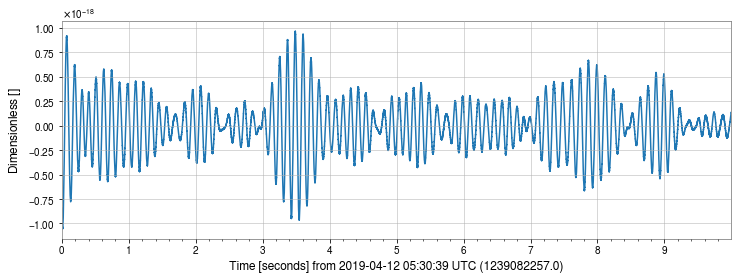

In [7]:
%matplotlib inline
plot = ldata.plot()

Notes: There are alternative ways to access the GWOSC data. 

* [`readligo`](https://losc.ligo.org/s/sample_code/readligo.py) is a light-weight Python module that returns the time series into a Numpy array.
* The [PyCBC](http://github.com/ligo-cbc/pycbc) package has the `pycbc.frame.query_and_read_frame` and `pycbc.frame.read_frame` methods. We use [PyCBC](http://github.com/ligo-cbc/pycbc) in Tutorial 2.1, 2.2 and 2.3. 

## Handling data in the frequency domain using the Fourier transform

The [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) is a widely-used mathematical tool to expose the frequency-domain content of a time-domain signal, meaning we can see which frequencies contain lots of power, and which have less.

We can calculate the Fourier transform of our `TimeSeries` using the [fft()](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/?highlight=fourier#gwpy.timeseries.TimeSeries.fft) method:

In [8]:
fft = ldata.fft()
print(fft)

FrequencySeries([-1.45894410e-21+0.00000000e+00j,
                 -2.91834926e-21-4.52905657e-23j,
                 -2.91973330e-21-9.06202944e-23j, ...,
                 -2.38723982e-23+4.67871178e-26j,
                 -2.38345362e-23+1.80394058e-26j,
                 -2.38457175e-23+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1239082257.0,
                name: Strain,
                channel: None)


The result is a [`FrequencySeries`](https://gwpy.github.io/docs/stable/api/gwpy.frequencyseries.FrequencySeries/#gwpy.frequencyseries.FrequencySeries), with complex amplitude, representing the amplitude and phase of each frequency in our data.
We can use `abs()` to extract the amplitude and plot it:

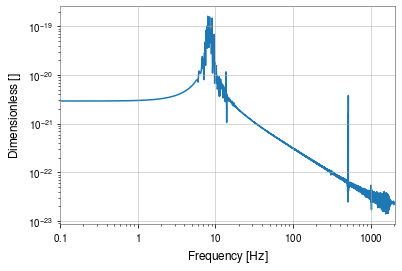

In [9]:
plot = fft.abs().plot(xscale="log", yscale="log")
plot.show(warn=False)

This doesn't look correct at all!
The problem is that the FFT works under the assumption that our data are periodic, which means that the edges of our data look like discontinuities when transformed.
We need to apply a window function to our time-domain data before transforming, which we can do using the [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html) module:

In [10]:
from scipy.signal import get_window
window = get_window('hann', ldata.size)
lwin = ldata * window

Let's try our transform again and see what we get

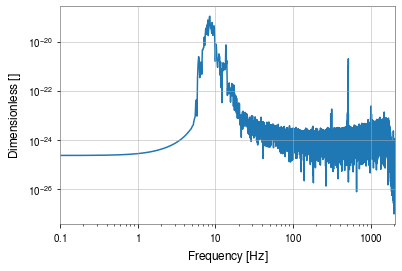

In [11]:
fftamp = lwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
plot.show(warn=False)

This looks a little more like what we expect for the amplitude spectral density of a gravitational-wave detector.

## Calculating the power spectral density

The dense fluctuations in the above plot at frequencies larger than 10 Hz seem completely random. This is indeed the intrinsic noise in the estimate of the spectral content of the signal from a single FFT. We can reduce these fluctuations by averaging many estimates of the singal FFT. But, being the FFT components complex quantities, what we really want to average are their squared moduli. This quantity is named [Power Spectral Density (PSD)](https://en.wikipedia.org/wiki/Spectral_density),  and what we have just described is [Welch's estimation method](https://en.wikipedia.org/wiki/Welch%27s_method).
It is also convinient to express the result not as a power but as an amplitude, taking the square root of the above eqpression. The resulting quantity takes the name Amplitude Spectral Density (ASD) of the signal.

GWpy library provides the [`asd()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/?highlight=asd#gwpy.timeseries.TimeSeries.asd) method, which uses Welch's method to combine FFTs estimated on overlapping, windowed chunks of data.

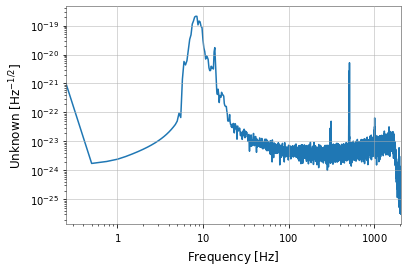

In [11]:
asd = ldata.asd(fftlength=4, method="median")
plot = asd.plot()
plot.show(warn=False)

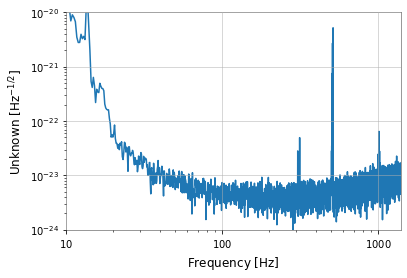

In [12]:
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(1e-24, 1e-20)
plot

The ASD is a standard tool used to study the frequency-domain sensitivity of a gravitational-wave detector.
For the LIGO-Livingston data we loaded, we can see large spikes at certain frequencies, including

- ~300 Hz
- ~500 Hz
- ~1000 Hz

The [O2 spectral lines](https://www.gw-openscience.org/o2speclines/) page on GWOSC describes a number of these spectral features for O2, with some of them being forced upon us, and some being deliberately introduced to help with interferometer control.

Loading more data allows for more FFTs to be averaged during the ASD calculation, meaning random variations get averaged out, and we can see more detail:

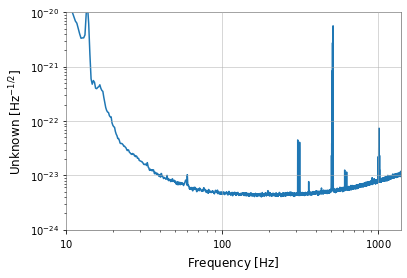

In [13]:
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")
plot = lasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(1e-24, 1e-20)
plot.show(warn=False)

Now we can see some more features, including sets of lines around ~30 Hz and ~65 Hz, and some more isolated lines through the more sensitive region.

For comparison, we can load the LIGO-Hanford data and plot that as well:

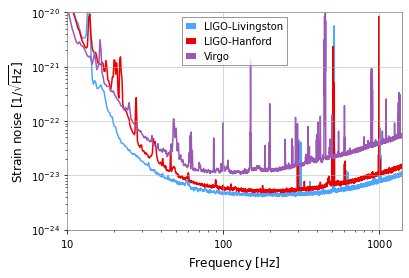

In [14]:
# get Hanford data
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")

# get Virgo data
vdata2 = TimeSeries.fetch_open_data('V1', int(gps)-512, int(gps)+512, cache=True)
vasd2 = vdata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(hasd2, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(vasd2, label='Virgo', color='gwpy:virgo')

# update the Livingston line to use standard colour, and have a label
lline = ax.lines[0]
lline.set_color('gwpy:ligo-livingston')  # change colour of Livingston data
lline.set_label('LIGO-Livingston')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

Now we can see clearly the relative sensitivity of each LIGO instrument, the common features between both, and those unique to each observatory.

# Challenges:

## Quiz Question 1:

The peak amplitude in the LIGO-Livingston data occurs at approximately 5 seconds into the plot above and is undetectable above the background noise by the eye. Plot the data for the LIGO-Hanford detector around GW190412. Looking at your new LIGO-Handford plot, can your eye identify a signal peak? 

## Quiz Question 2 :

Make an ASD around the time of an O1 event, GW150914 for L1 detector.  Compare this with the ASDs around GW190412 for L1 detector.  Which data have lower noise - and so are more sensitive - around 100 Hz?
